In [66]:
# Imports

import pandas as pd
import warnings
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from plotnine import *
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Reading Dataset

filepath = 'data/AirPassengers.csv'
data = pd.read_csv(filepath)
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# Missing Vals

data.isna().sum()

Month          0
#Passengers    0
dtype: int64

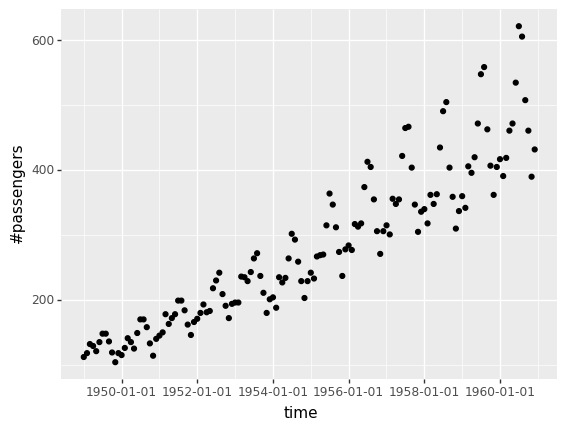

<ggplot: (8778347648693)>

In [4]:
# Plot Data

plot = (ggplot(data, aes(x='Month', y='#Passengers')) +
         geom_point() +
         labs(x='time', y='#passengers') +
         scale_x_datetime()
)
plot

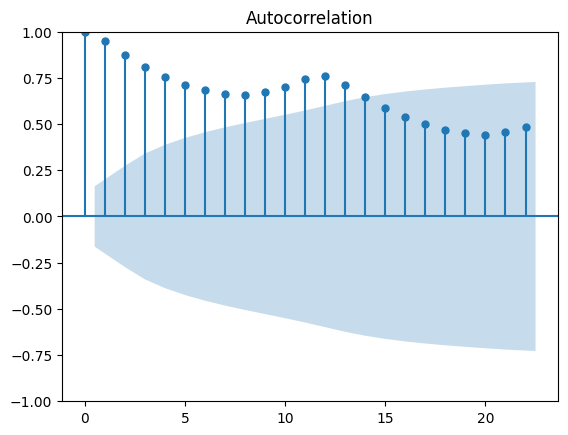

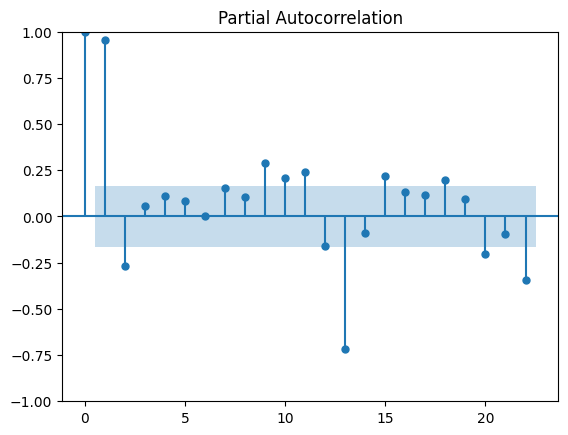

In [5]:
# PACF & ACF Plot

plot_acf(data['#Passengers']);
plot_pacf(data['#Passengers']);

In [6]:
# Adfuller Test

adfuller_result = adfuller(data['#Passengers'])
print(f'ADF Stat: {adfuller_result[0]}')
print(f'P Value: {adfuller_result[1]}')

ADF Stat: 0.8153688792060472
P Value: 0.991880243437641


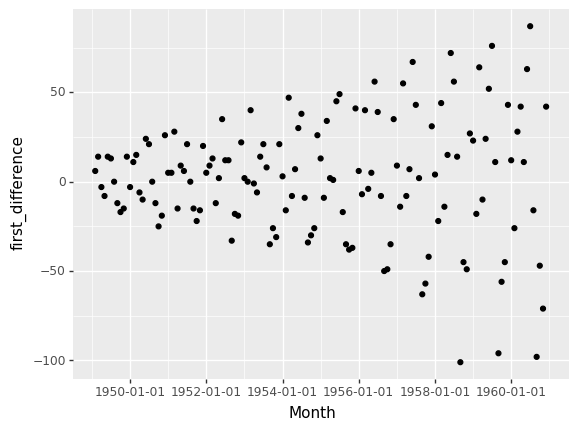

<ggplot: (8778350775881)>

In [27]:
# First Order Differencing

data['first_difference'] = data['#Passengers'].diff()

plot = (ggplot(data[1:].reset_index(drop=True), aes(x='Month', y='first_difference')) + 
        geom_point() +
        scale_x_datetime()
        )   
plot

In [28]:
# Adfuller Test

adfuller_result = adfuller(data['first_difference'][1:])
print(f'ADF Stat: {adfuller_result[0]}')
print(f'P Value: {adfuller_result[1]}')

ADF Stat: -2.8292668241700056
P Value: 0.054213290283824704


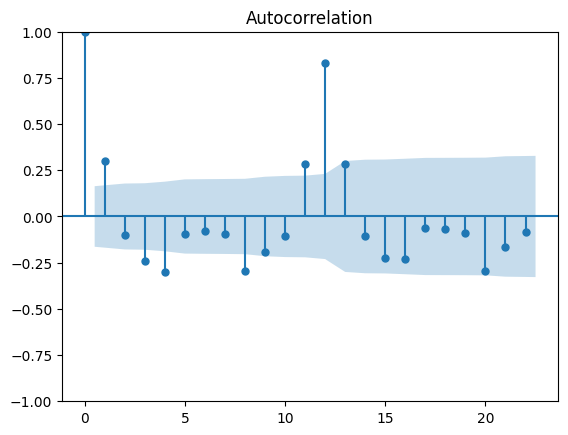

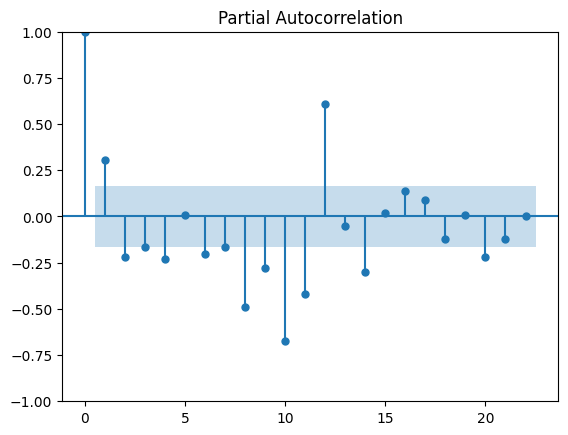

In [29]:
plot_acf(data['first_difference'][1:]);
plot_pacf(data['first_difference'][1:]);

In [32]:
# Setting up Data for Modelling

print(f'Total Data: {len(data)}')
TEST_SIZE = 24

train, test = data[:-TEST_SIZE], data[TEST_SIZE:]
train

Total Data: 144


,Month,#Passengers,first_difference
0,1949-01,112,NaN
1,1949-02,118,6.0
2,1949-03,132,14.0
3,1949-04,129,-3.0
4,1949-05,121,-8.0
...,...,...,...
115,1958-08,505,14.0
116,1958-09,404,-101.0
117,1958-10,359,-45.0
118,1958-11,310,-49.0


In [82]:
# Train Model

model = auto_arima(y=train['#Passengers'],
                   start_p=1,
                   start_q=1,
                   max_p=8,
                   max_q=8,
                   seasonal=True,
                   max_d=2,
                   information_criterion='aic',
                   start_P=1,
                   start_Q=1,
                   m=12,
                   suppress_warnings=True,
                   trace=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=812.285, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=0.40 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.05 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.24 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.15 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=809.375, Time=0.09 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.09 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept  

In [83]:
model.summary()


# According to the model summary, the model meets the condition of independence in the residuals (no correlation) because the p-value of the Ljung-Box test (Prob(Q)) is greater than 0.05, so we cannot reject the null hypothesis of independence. 
# We can say that the residual distribution is homoscedastic (constant variance) because the p-value of the Heteroskedasticity test (Prob(H)) is greater than 0.05.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Tue, 09 May 2023   AIC                            808.863
Time:                                    00:33:28   BIC                            819.592
Sample:                                         0   HQIC                           813.213
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.93   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
# Prediction

prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)
prediction

120    345.739350
121    326.334142
122    372.828949
123    360.923494
124    377.731027
125    451.281824
126    508.613978
127    523.758019
128    423.740565
129    379.584404
130    331.309117
131    358.931522
132    368.205412
133    349.259283
134    396.148362
135    384.581517
136    401.679860
137    475.480413
138    533.027064
139    548.355323
140    448.496080
141    404.475794
142    356.317202
143    384.039828
dtype: float64

In [85]:
# Error

mape = mean_absolute_percentage_error(data['#Passengers'][-TEST_SIZE:], prediction)
print(f'MAPE: {round(mape, 3)}%')


MAPE: 0.094%


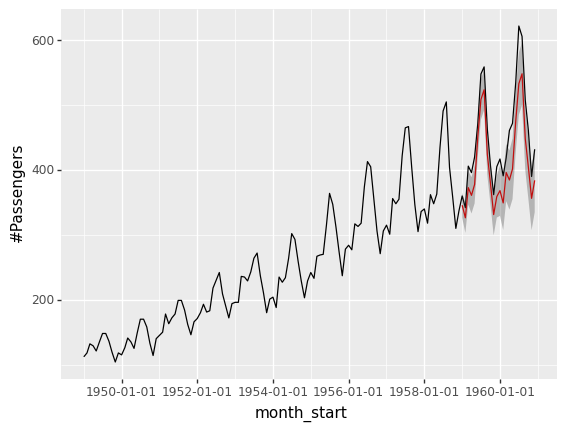

<ggplot: (8778359046181)>

In [86]:
# Plot

data['prediction'] = prediction
confidence_int = pd.DataFrame(confint, columns=['ll', 'ul'], index=prediction.index)
prediction_frame = data.join(confidence_int)
prediction_frame['month_start'] = pd.to_datetime(prediction_frame['Month'])


plot = (ggplot(prediction_frame) + 
geom_line(aes(x='month_start', y='#Passengers')) +
geom_line(aes(x='month_start', y='prediction'), color='red') +
geom_ribbon(aes(x='month_start', ymax='ul', ymin='ll'), alpha=0.3)
)
plot

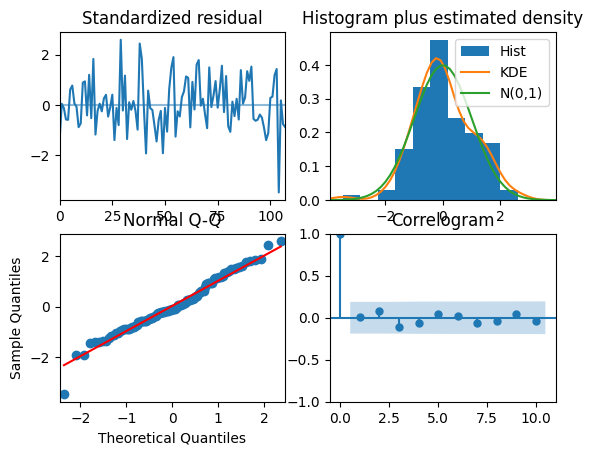

In [87]:
model.plot_diagnostics();

In [101]:
# Future Prediction

future_predictions, conf_int = model.fit(data['#Passengers']).predict(n_periods=24, return_conf_int=True)
future_predictions

144    444.889177
145    419.206848
146    447.585620
147    489.879214
148    501.134991
149    564.350079
150    651.532842
151    635.687659
152    537.818923
153    490.930188
154    420.024508
155    462.104461
156    475.061414
157    449.436538
158    477.864013
159    520.198891
160    531.489665
161    594.734419
162    681.942330
163    666.118464
164    568.267799
165    521.394382
166    450.501687
167    492.592648
dtype: float64

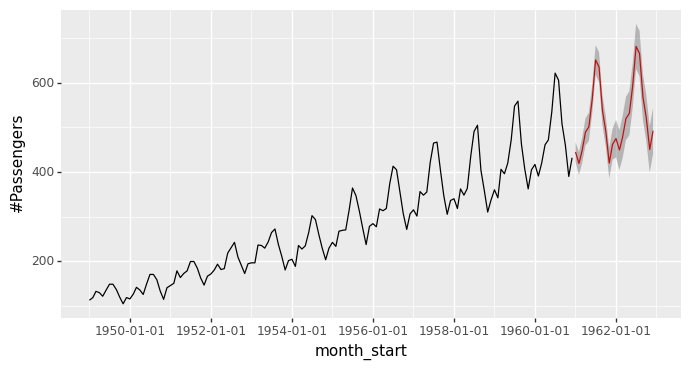

<ggplot: (8778355197660)>

In [138]:
# Future Plot

prediction_frame[['prediction', 'ul', 'll']] = pd.NA
dateframe = pd.DataFrame(pd.date_range(start=prediction_frame['month_start'].iloc[-1] + pd.DateOffset(months=1),
                                       periods=24,
                                       freq='MS'),
                         columns=['month_start'],
                         index=range(prediction_frame.index[-1]+1, prediction_frame.index[-1]+24+1)
                         )

dateframe['prediction'] = future_predictions
conf_int = pd.DataFrame(conf_int, columns=['ll', 'ul'], index=dateframe.index)

dateframe['ul'] = conf_int['ul']
dateframe['ll'] = conf_int['ll']

final_predictions = pd.concat([prediction_frame, dateframe])

plot = (ggplot(final_predictions) + 
geom_line(aes(x='month_start', y='#Passengers')) +
geom_line(aes(x='month_start', y='prediction'), color='red') +
geom_ribbon(aes(x='month_start', ymax='ul', ymin='ll'), alpha=0.3) +
theme(figure_size=(8, 4))
)
plot


In [139]:
final_predictions.tail(30)

,Month,#Passengers,first_difference,prediction,ll,ul,month_start
138,1960-07,622.0,87.0,NaN,NaN,NaN,1960-07-01
139,1960-08,606.0,-16.0,NaN,NaN,NaN,1960-08-01
140,1960-09,508.0,-98.0,NaN,NaN,NaN,1960-09-01
141,1960-10,461.0,-47.0,NaN,NaN,NaN,1960-10-01
142,1960-11,390.0,-71.0,NaN,NaN,NaN,1960-11-01
143,1960-12,432.0,42.0,NaN,NaN,NaN,1960-12-01
144,NaN,NaN,NaN,444.889177,422.786547,466.991807,1961-01-01
145,NaN,NaN,NaN,419.206848,393.469329,444.944367,1961-02-01
146,NaN,NaN,NaN,447.585620,418.941835,476.229406,1961-03-01
147,NaN,NaN,NaN,489.879214,459.437432,520.320996,1961-04-01
